# 🚗 차량 사운드 데이터 EDA

이 노트북에서는 차량 사운드 데이터를 탐색하고 분석합니다.

- 데이터 구조 확인
- 클래스 분포 시각화
- Waveform / Mel Spectrogram / MFCC 분석
- 정상 vs 비정상 비교


In [ ]:
# ============================================================
# 필수 라이브러리 임포트
# ============================================================

import os
import sys

# 상위 디렉토리를 path에 추가 (app 모듈 사용을 위해)
sys.path.insert(0, '..')

# 데이터 처리 및 수치 계산
import numpy as np      # 수치 연산 라이브러리
import pandas as pd     # 데이터프레임 처리

# 시각화 라이브러리
import matplotlib.pyplot as plt  # 기본 그래프
import seaborn as sns            # 고급 시각화

# 오디오 처리 라이브러리
import librosa              # 오디오 분석의 핵심 라이브러리
import librosa.display      # 오디오 시각화 (스펙트로그램 등)

# 유틸리티
from pathlib import Path           # 경로 처리
from collections import Counter    # 빈도 계산
import warnings
warnings.filterwarnings('ignore')  # 경고 메시지 숨김

# ============================================================
# 시각화 스타일 설정
# ============================================================
plt.style.use('seaborn-v0_8-whitegrid')  # 깔끔한 그리드 스타일
plt.rcParams['figure.figsize'] = (12, 6)  # 기본 그래프 크기
plt.rcParams['font.size'] = 12            # 기본 폰트 크기
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# ============================================================
# 영어 → 한글 번역 딕셔너리
# ============================================================

# 상태(State)
STATE_KO = {
    'braking state': '브레이크 상태',
    'idle state': '공회전 상태',
    'startup state': '시동 상태',
}

# 문제(Problem)
PROBLEM_KO = {
    # 브레이크 관련
    'normal_brakes': '정상 브레이크',
    'worn_out_brakes': '마모된 브레이크',
    
    # 공회전 관련
    'normal_engine_idle': '정상 공회전',
    'low_oil': '오일 부족',
    'no oil': '오일 없음',
    'exhaust_leak': '배기 누출',
    'misfire': '점화 실패',
    'vacuum_leak': '진공 누출',
    'power_steering': '파워스티어링 이상',
    'power steering combined': '파워스티어링 복합',
    'serpentine_belt': '구동벨트 이상',
    'no oil_serpentine belt': '오일없음+구동벨트',
    'power steering combined_serpentine belt': '파워스티어링+구동벨트',
    'power steering combined_no oil': '파워스티어링+오일없음',
    'power steering combined_no oil_serpentine belt': '파워스티어링+오일없음+구동벨트',
    'combined': '복합 이상',
    
    # 시동 관련
    'normal_engine_startup': '정상 시동',
    'bad_ignition': '점화 불량',
    'dead_battery': '배터리 방전',
    'bad_starter': '스타터 불량',
    'fuel_pump_issue': '연료펌프 문제',
}

def translate_state(eng_name):
    """영어 상태명을 한글로 번역"""
    return STATE_KO.get(eng_name, eng_name)

def translate_problem(eng_name: str) -> str:
    """영어 문제명을 한글로 번역"""
    # 슬래시가 있는 경우 (예: "combined/normal")
    if '/' in eng_name:
        parts = eng_name.split('/')
        translated = [PROBLEM_KO.get(p, p) for p in parts]
        return '/'.join(str(t) for t in translated)
    return PROBLEM_KO.get(eng_name, eng_name)

print("✅ 라이브러리 로드 완료!")
print("✅ 한글 번역 딕셔너리 설정 완료!")


✅ 라이브러리 로드 완료!
✅ 한글 번역 딕셔너리 설정 완료!


## 1. 데이터 구조 확인


In [ ]:
# ============================================================
# 데이터 디렉토리 구조 탐색
# ============================================================
# 
# 데이터 구조:
#   data/
#   ├── braking state/         <- 브레이크 상태
#   │   ├── normal_brakes/     <- 정상 브레이크
#   │   └── worn_out_brakes/   <- 마모된 브레이크
#   ├── idle state/            <- 공회전 상태
#   │   ├── normal_engine_idle/
#   │   ├── low_oil/
#   │   └── ...
#   └── startup state/         <- 시동 상태
#       ├── normal_engine_startup/
#       ├── bad_ignition/
#       └── dead_battery/

data_dir = Path('../data')

# 각 클래스별 정보를 저장할 리스트
data_info = []

# 1단계: 상태(state) 디렉토리 순회 (braking, idle, startup)
for state_dir in sorted(data_dir.iterdir()):
    if not state_dir.is_dir():
        continue
    state_name = state_dir.name  # 예: "braking state"
    
    # 2단계: 문제(problem) 디렉토리 순회 (normal_brakes, worn_out_brakes 등)
    for problem_dir in sorted(state_dir.iterdir()):
        if not problem_dir.is_dir():
            continue
        problem_name = problem_dir.name  # 예: "normal_brakes"
        
        # 해당 폴더의 WAV 파일 수집
        wav_files = list(problem_dir.glob('*.wav'))
        
        # 3단계: 하위 폴더가 있는지 확인 (combined 폴더 내부)
        for sub_dir in problem_dir.iterdir():
            if sub_dir.is_dir():
                sub_files = list(sub_dir.glob('*.wav'))
                data_info.append({
                    'state': state_name,
                    'problem': f"{problem_name}/{sub_dir.name}",
                    'count': len(sub_files),
                    'path': str(sub_dir)
                })
        
        # 직접 WAV 파일이 있는 경우
        if wav_files:
            data_info.append({
                'state': state_name,
                'problem': problem_name,
                'count': len(wav_files),
                'path': str(problem_dir)
            })

# DataFrame으로 변환하여 보기 좋게 출력
df_info = pd.DataFrame(data_info)

# ============================================================
# 한글 번역 컬럼 추가
# ============================================================
# 영어 -> 한글 변환 적용
df_info['상태'] = df_info['state'].apply(translate_state)
df_info['문제'] = df_info['problem'].apply(translate_problem)

# 한글 컬럼만 남기고 영어 컬럼 제거
df_info = df_info[['상태', '문제', 'count', 'path']].copy()
df_info = df_info.rename(columns={'count': '샘플수'})  # type: ignore

print("=" * 50)
print(f"📊 총 클래스 수: {len(df_info)}")
print(f"📁 총 샘플 수: {df_info['샘플수'].sum()}")
print("=" * 50)

df_info


📊 총 클래스 수: 22
📁 총 샘플 수: 3269


,상태,문제,샘플수,path
0,augmented,braking state/정상 브레이크,231,..\data\augmented\braking state\normal_brakes
1,augmented,braking state/마모된 브레이크,228,..\data\augmented\braking state\worn_out_brakes
2,augmented,idle state/복합 이상,0,..\data\augmented\idle state\combined
3,augmented,idle state/오일 부족,214,..\data\augmented\idle state\low_oil
4,augmented,idle state/파워스티어링 이상,258,..\data\augmented\idle state\power_steering
5,augmented,idle state/구동벨트 이상,232,..\data\augmented\idle state\serpentine_belt
6,augmented,startup state/점화 불량,248,..\data\augmented\startup state\bad_ignition
7,augmented,startup state/배터리 방전,228,..\data\augmented\startup state\dead_battery
8,augmented,startup state/정상 시동,244,..\data\augmented\startup state\normal_engine_...
9,브레이크 상태,정상 브레이크,77,..\data\braking state\normal_brakes


## 2. 클래스 분포 시각화

데이터셋의 클래스별 샘플 수를 시각화하여 **클래스 불균형** 여부를 확인합니다.


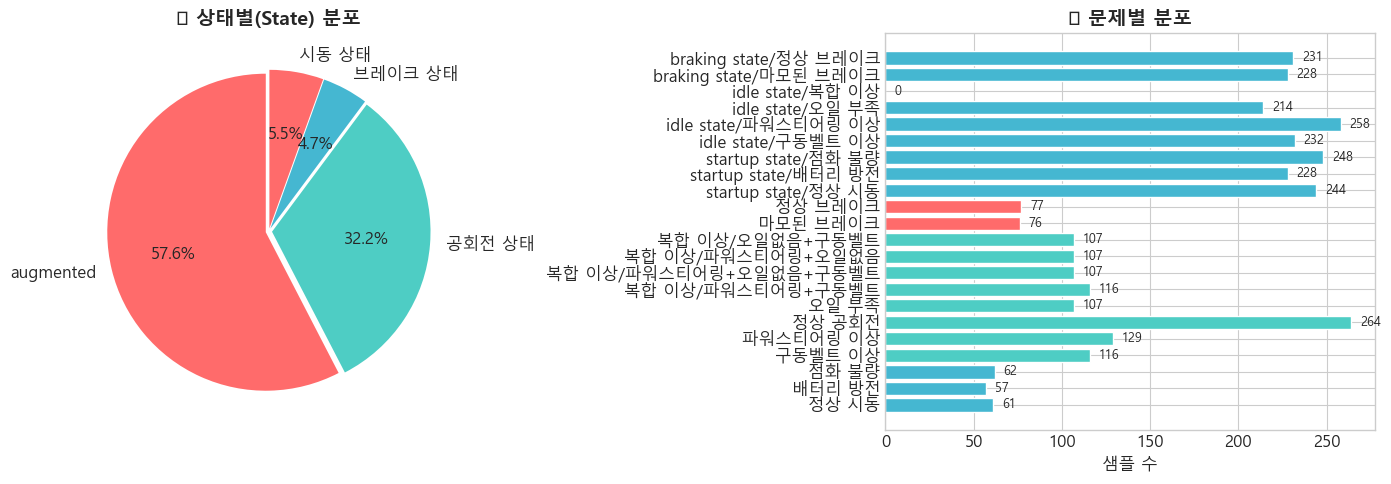


📊 클래스별 샘플 수:
                    문제  샘플수
                정상 공회전  264
  idle state/파워스티어링 이상  258
   startup state/점화 불량  248
   startup state/정상 시동  244
    idle state/구동벨트 이상  232
 braking state/정상 브레이크  231
braking state/마모된 브레이크  228
  startup state/배터리 방전  228
      idle state/오일 부족  214
             파워스티어링 이상  129
               구동벨트 이상  116
     복합 이상/파워스티어링+구동벨트  116
                 오일 부족  107
       복합 이상/오일없음+구동벨트  107
     복합 이상/파워스티어링+오일없음  107
복합 이상/파워스티어링+오일없음+구동벨트  107
               정상 브레이크   77
              마모된 브레이크   76
                 점화 불량   62
                 정상 시동   61
                배터리 방전   57
      idle state/복합 이상    0


In [ ]:
# ============================================================
# 클래스 분포 시각화
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ----- 좌측: 상태별(State) 파이 차트 -----
# 브레이크/공회전/시동 상태별 샘플 비율 (한글 사용)
state_counts = df_info.groupby('상태')['샘플수'].sum()
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']  # 빨강, 청록, 파랑

axes[0].pie(
    state_counts, 
    labels=state_counts.index, 
    autopct='%1.1f%%',  # 퍼센트 표시
    startangle=90,
    colors=colors,
    explode=[0.02] * len(state_counts)  # 조각 분리
)
axes[0].set_title('🚗 상태별(State) 분포', fontsize=14, fontweight='bold')

# ----- 우측: 문제별(Problem) 바 차트 -----
# 각 세부 문제별 샘플 수 (한글 사용)
colors_bar = ['#FF6B6B' if '브레이크' in s else '#4ECDC4' if '공회전' in s else '#45B7D1' 
              for s in df_info['상태']]

axes[1].barh(df_info['문제'], df_info['샘플수'], color=colors_bar, edgecolor='white')
axes[1].set_xlabel('샘플 수', fontsize=12)
axes[1].set_title('🔧 문제별 분포', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()  # 위에서 아래로 정렬

# 샘플 수 라벨 추가
for i, (count, problem) in enumerate(zip(df_info['샘플수'], df_info['문제'])):
    axes[1].text(count + 5, i, str(count), va='center', fontsize=9)

plt.tight_layout()
plt.show()

# 클래스 불균형 확인
print("\n📊 클래스별 샘플 수:")
df_sorted = df_info[['문제', '샘플수']].sort_values('샘플수', ascending=False)  # type: ignore
print(df_sorted.to_string(index=False))


## 3. 오디오 파일 로드 및 기본 분석

오디오 파일을 로드하고 기본 정보를 확인합니다.

**핵심 개념:**
- **Sample Rate (샘플링 레이트)**: 1초당 샘플 수 (Hz). 22050Hz = 1초에 22050개 샘플
- **Duration (길이)**: 오디오 파일의 총 길이 (초)
- **Waveform (파형)**: 시간에 따른 진폭의 변화


In [21]:
# ============================================================
# 오디오 로드 함수 정의
# ============================================================

def load_audio(file_path, sr=22050):
    """
    오디오 파일을 로드하는 함수
    
    Parameters:
    -----------
    file_path : str
        오디오 파일 경로
    sr : int
        샘플링 레이트 (기본값: 22050Hz)
        - 22050Hz: 일반적인 음악/음성 분석에 충분
        - 44100Hz: CD 품질
        - 16000Hz: 음성 인식에 주로 사용
    
    Returns:
    --------
    y : np.ndarray
        오디오 시계열 데이터 (1D 배열)
    sr : int
        샘플링 레이트
    """
    y, sr = librosa.load(file_path, sr=sr)
    return y, sr


def get_audio_info(y, sr):
    """
    오디오 기본 정보를 반환하는 함수
    
    Parameters:
    -----------
    y : np.ndarray
        오디오 시계열 데이터
    sr : int
        샘플링 레이트
    
    Returns:
    --------
    dict : 오디오 정보 딕셔너리
    """
    return {
        '샘플링 레이트': f"{sr} Hz",
        '총 샘플 수': len(y),
        '길이 (초)': f"{len(y)/sr:.2f}초",
        '최소값': f"{y.min():.4f}",
        '최대값': f"{y.max():.4f}",
        '평균': f"{y.mean():.6f}",
        '표준편차': f"{y.std():.4f}"
    }

print("✅ 오디오 로드 함수 정의 완료!")


✅ 오디오 로드 함수 정의 완료!


In [22]:
# ============================================================
# 샘플 오디오 파일 로드
# ============================================================

# 각 상태별 첫 번째 샘플 파일 경로 가져오기
sample_files = {}

# 정상 브레이크
sample_files['정상 브레이크'] = list((data_dir / 'braking state' / 'normal_brakes').glob('*.wav'))[0]
# 마모된 브레이크
sample_files['마모된 브레이크'] = list((data_dir / 'braking state' / 'worn_out_brakes').glob('*.wav'))[0]
# 정상 공회전
sample_files['정상 공회전'] = list((data_dir / 'idle state' / 'normal_engine_idle').glob('*.wav'))[0]
# 오일 부족
sample_files['오일 부족'] = list((data_dir / 'idle state' / 'low_oil').glob('*.wav'))[0]
# 정상 시동
sample_files['정상 시동'] = list((data_dir / 'startup state' / 'normal_engine_startup').glob('*.wav'))[0]
# 배터리 방전
sample_files['배터리 방전'] = list((data_dir / 'startup state' / 'dead_battery').glob('*.wav'))[0]

print("📂 샘플 파일 목록:")
for name, path in sample_files.items():
    print(f"  • {name}: {path.name}")


📂 샘플 파일 목록:
  • 정상 브레이크: normal_brakes_1.wav
  • 마모된 브레이크: worn_out_brakes_1.wav
  • 정상 공회전: normal_engine_idle_1.wav
  • 오일 부족: low_oil_1.wav
  • 정상 시동: normal_engine_startup_1.wav
  • 배터리 방전: dead_battery_1.wav


In [23]:
# ============================================================
# 첫 번째 샘플 로드 및 정보 확인
# ============================================================

# 정상 브레이크 샘플 로드
sample_name = '정상 브레이크'
y, sr = load_audio(sample_files[sample_name])

# 오디오 정보 출력
print(f"🔊 '{sample_name}' 오디오 정보:")
print("=" * 40)
info = get_audio_info(y, sr)
for key, value in info.items():
    print(f"  {key}: {value}")


🔊 '정상 브레이크' 오디오 정보:
  샘플링 레이트: 22050 Hz
  총 샘플 수: 33075
  길이 (초): 1.50초
  최소값: -0.1345
  최대값: 0.1432
  평균: -0.000219
  표준편차: 0.0395


## 4. Waveform (파형) 시각화

**Waveform**은 시간에 따른 오디오 신호의 진폭 변화를 보여줍니다.
- X축: 시간 (초)
- Y축: 진폭 (-1 ~ 1 사이 정규화)
- 진폭이 클수록 소리가 큼


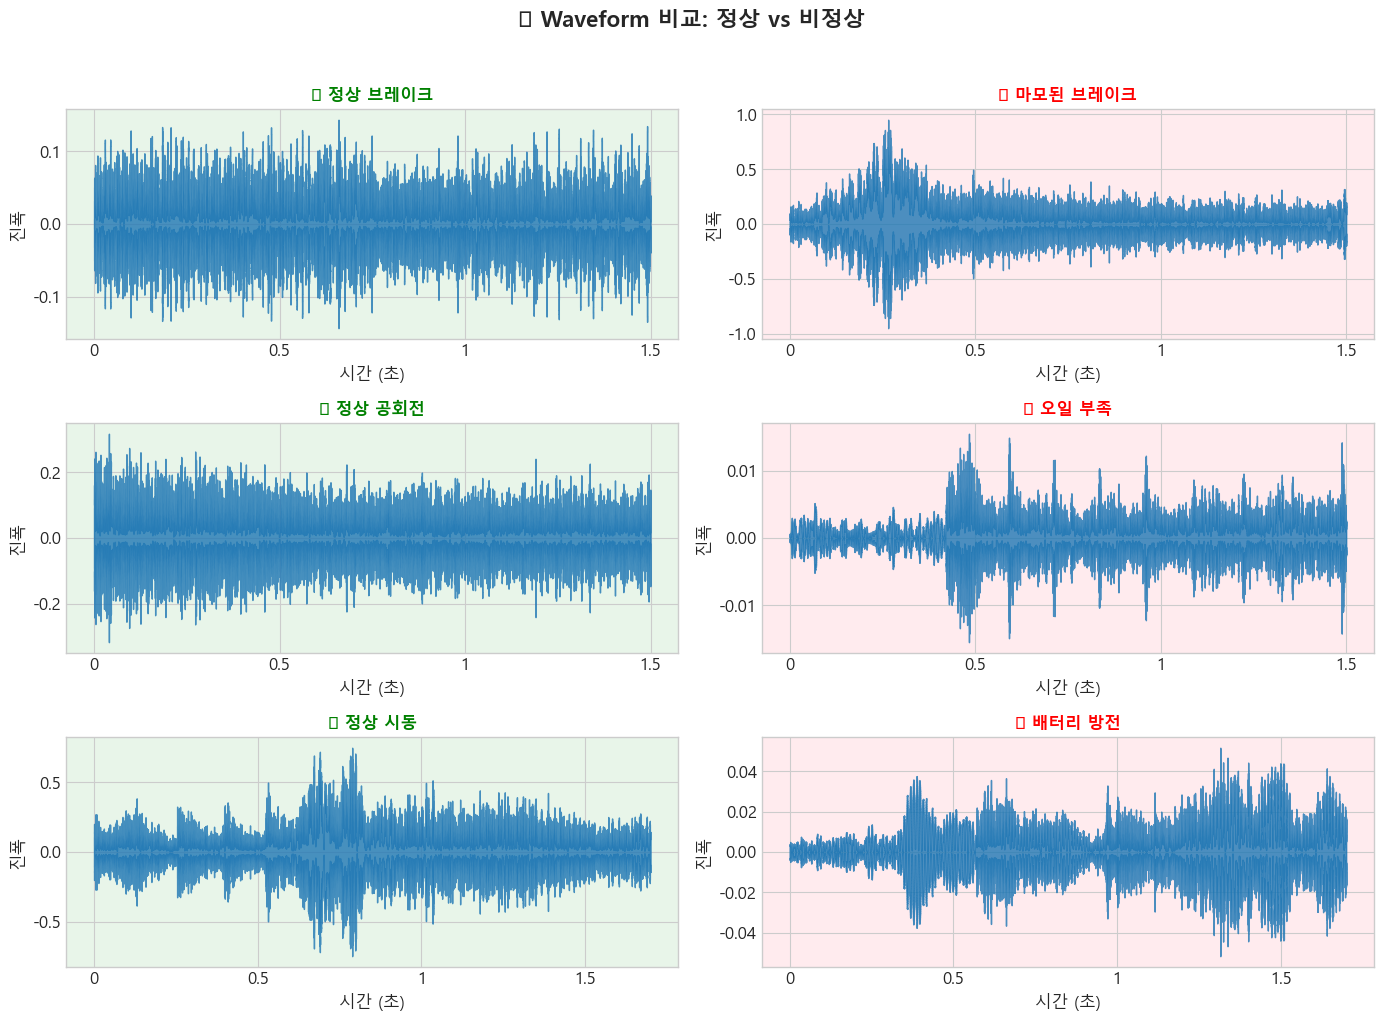


💡 관찰 포인트:
  • 정상 소리와 비정상 소리의 진폭 패턴 차이를 비교해보세요
  • 비정상 소리는 불규칙한 패턴이나 노이즈가 있을 수 있습니다


In [24]:
# ============================================================
# 여러 샘플의 Waveform 비교
# ============================================================

fig, axes = plt.subplots(3, 2, figsize=(14, 10))
axes = axes.flatten()

# 각 샘플에 대해 Waveform 그리기
for idx, (name, path) in enumerate(sample_files.items()):
    # 오디오 로드
    y_sample, sr_sample = load_audio(path)
    
    # Waveform 시각화
    # librosa.display.waveshow: 파형을 시각화하는 함수
    librosa.display.waveshow(y_sample, sr=sr_sample, ax=axes[idx], alpha=0.8)
    
    # 정상/비정상 색상 구분
    if '정상' in name:
        axes[idx].set_facecolor('#E8F5E9')  # 연한 초록 배경
        title_color = 'green'
    else:
        axes[idx].set_facecolor('#FFEBEE')  # 연한 빨강 배경
        title_color = 'red'
    
    axes[idx].set_title(f'🔊 {name}', fontsize=12, fontweight='bold', color=title_color)
    axes[idx].set_xlabel('시간 (초)')
    axes[idx].set_ylabel('진폭')

plt.suptitle('📊 Waveform 비교: 정상 vs 비정상', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n💡 관찰 포인트:")
print("  • 정상 소리와 비정상 소리의 진폭 패턴 차이를 비교해보세요")
print("  • 비정상 소리는 불규칙한 패턴이나 노이즈가 있을 수 있습니다")


## 5. Mel Spectrogram (멜 스펙트로그램)

**Mel Spectrogram**은 오디오의 주파수 성분을 시간에 따라 시각화합니다.

**핵심 개념:**
- **Spectrogram**: 시간-주파수-강도를 2D 이미지로 표현
- **Mel Scale**: 인간의 청각 특성을 반영한 주파수 스케일
  - 저주파수에서 더 세밀하게, 고주파수에서 덜 세밀하게 표현
- **dB (데시벨)**: 로그 스케일로 변환하여 인간의 청각에 맞춤

딥러닝 모델은 주로 Mel Spectrogram을 입력으로 사용합니다.


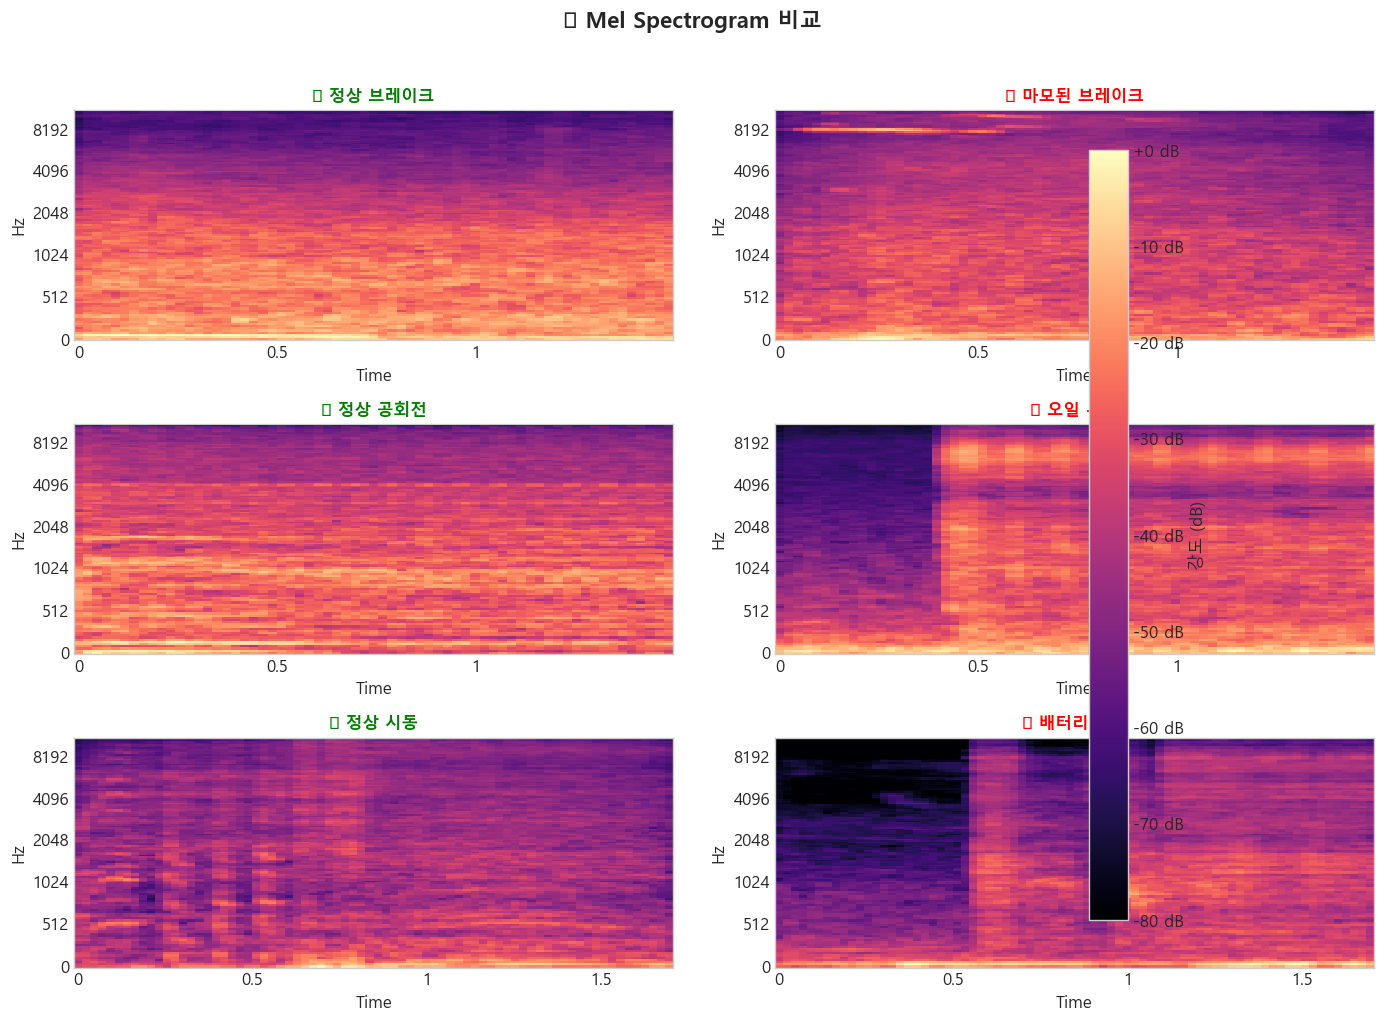


💡 해석 방법:
  • 밝은 색(노랑): 해당 주파수에서 에너지가 높음 (소리가 큼)
  • 어두운 색(검정/보라): 에너지가 낮음
  • 가로 줄무늬: 특정 주파수에서 지속적인 소리 (예: 엔진 소음)
  • 세로 줄무늬: 순간적인 충격음 (예: 브레이크 소음)


In [25]:
# ============================================================
# Mel Spectrogram 추출 및 시각화
# ============================================================

fig, axes = plt.subplots(3, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, (name, path) in enumerate(sample_files.items()):
    # 오디오 로드
    y_sample, sr_sample = load_audio(path)
    
    # ----- Mel Spectrogram 계산 -----
    # n_mels: Mel 필터뱅크 수 (기본 128)
    # n_fft: FFT 윈도우 크기 (주파수 해상도 결정)
    # hop_length: 윈도우 이동 간격 (시간 해상도 결정)
    mel_spec = librosa.feature.melspectrogram(
        y=y_sample, 
        sr=sr_sample,
        n_mels=128,      # Mel 밴드 수
        n_fft=2048,      # FFT 포인트 수
        hop_length=512   # 홉 길이
    )
    
    # ----- 데시벨(dB) 스케일로 변환 -----
    # power_to_db: 파워 스펙트로그램을 dB로 변환
    # ref=np.max: 최대값을 기준으로 정규화 (0dB가 최대)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    
    # ----- 시각화 -----
    img = librosa.display.specshow(
        mel_spec_db,
        sr=sr_sample,
        hop_length=512,
        x_axis='time',   # X축: 시간
        y_axis='mel',    # Y축: Mel 주파수
        ax=axes[idx],
        cmap='magma'     # 컬러맵 (magma: 검정-보라-노랑)
    )
    
    # 정상/비정상 색상 구분
    title_color = 'green' if '정상' in name else 'red'
    axes[idx].set_title(f'🎵 {name}', fontsize=12, fontweight='bold', color=title_color)

# 컬러바 추가
fig.colorbar(img, ax=axes, format='%+2.0f dB', label='강도 (dB)')

plt.suptitle('📊 Mel Spectrogram 비교', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n💡 해석 방법:")
print("  • 밝은 색(노랑): 해당 주파수에서 에너지가 높음 (소리가 큼)")
print("  • 어두운 색(검정/보라): 에너지가 낮음")
print("  • 가로 줄무늬: 특정 주파수에서 지속적인 소리 (예: 엔진 소음)")
print("  • 세로 줄무늬: 순간적인 충격음 (예: 브레이크 소음)")


## 6. MFCC (Mel-Frequency Cepstral Coefficients)

**MFCC**는 오디오의 스펙트럼 특성을 압축하여 표현하는 피처입니다.

**핵심 개념:**
- 음성/사운드 인식에서 가장 널리 사용되는 피처
- Mel Spectrogram에서 DCT(이산 코사인 변환)를 적용하여 추출
- 보통 13~40개의 계수를 사용
- 낮은 계수: 전체적인 스펙트럼 형태 (음색)
- 높은 계수: 세부적인 스펙트럼 변화


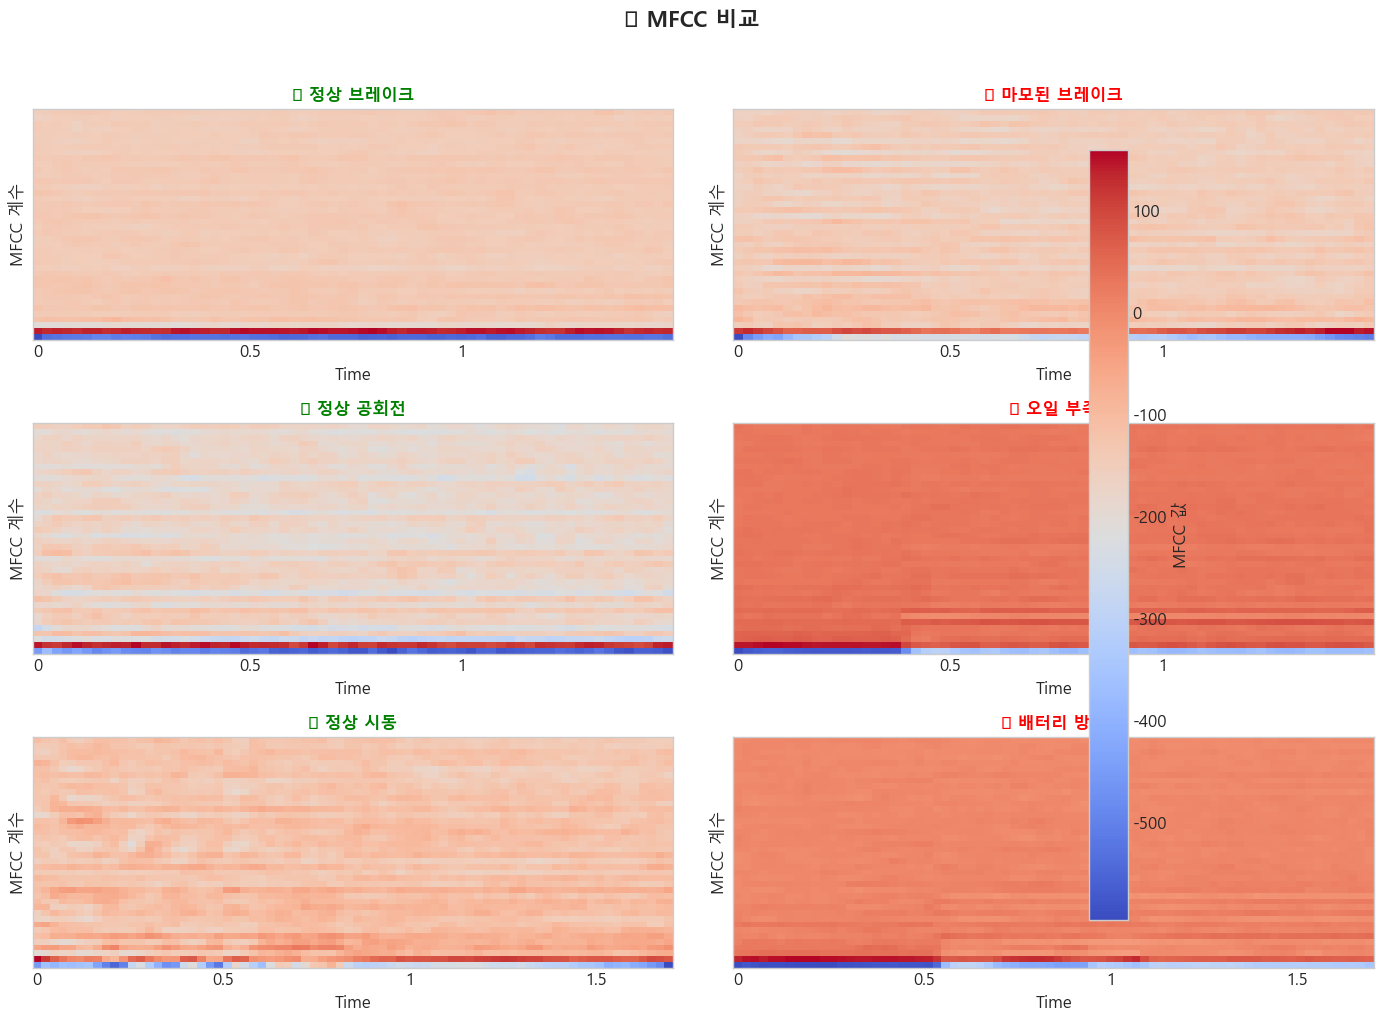


💡 MFCC 해석:
  • 낮은 계수 (아래쪽): 전체적인 소리의 특성
  • 높은 계수 (위쪽): 세부적인 스펙트럼 변화
  • 빨간색: 양수 값, 파란색: 음수 값


In [26]:
# ============================================================
# MFCC 추출 및 시각화
# ============================================================

fig, axes = plt.subplots(3, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, (name, path) in enumerate(sample_files.items()):
    # 오디오 로드
    y_sample, sr_sample = load_audio(path)
    
    # ----- MFCC 계산 -----
    # n_mfcc: 추출할 MFCC 계수의 수
    #   - 13: 전통적인 음성 인식
    #   - 40: 더 상세한 정보 포함
    mfcc = librosa.feature.mfcc(
        y=y_sample, 
        sr=sr_sample,
        n_mfcc=40,       # 40개의 MFCC 계수
        n_fft=2048,
        hop_length=512
    )
    
    # ----- 시각화 -----
    img = librosa.display.specshow(
        mfcc,
        sr=sr_sample,
        hop_length=512,
        x_axis='time',
        ax=axes[idx],
        cmap='coolwarm'  # 파랑-빨강 컬러맵
    )
    
    # 정상/비정상 색상 구분
    title_color = 'green' if '정상' in name else 'red'
    axes[idx].set_title(f'🎼 {name}', fontsize=12, fontweight='bold', color=title_color)
    axes[idx].set_ylabel('MFCC 계수')

# 컬러바 추가
fig.colorbar(img, ax=axes, label='MFCC 값')

plt.suptitle('📊 MFCC 비교', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n💡 MFCC 해석:")
print("  • 낮은 계수 (아래쪽): 전체적인 소리의 특성")
print("  • 높은 계수 (위쪽): 세부적인 스펙트럼 변화")
print("  • 빨간색: 양수 값, 파란색: 음수 값")


## 7. 프로젝트 피처 추출기 테스트

프로젝트에서 구현한 AudioFeatureExtractor를 사용하여 피처를 추출해봅니다.


In [27]:
# ============================================================
# 프로젝트 피처 추출기 임포트 및 테스트
# ============================================================

# 프로젝트의 피처 추출기와 설정 클래스 임포트
from app.ml.features.extractor import AudioFeatureExtractor, AudioConfig

# 오디오 처리 설정 생성
# AudioConfig는 dataclass로 정의된 설정 클래스
config = AudioConfig(
    sample_rate=22050,  # 샘플링 레이트 (Hz)
    duration=5.0,       # 분석할 오디오 길이 (초)
    n_mels=128,         # Mel 밴드 수 (스펙트로그램 세로 해상도)
    n_mfcc=40,          # MFCC 계수 수
    n_fft=2048,         # FFT 윈도우 크기
    hop_length=512      # 프레임 간 이동 거리
)

# 피처 추출기 인스턴스 생성
extractor = AudioFeatureExtractor(config=config)

print("✅ AudioFeatureExtractor 생성 완료!")
print(f"  📌 Sample Rate: {config.sample_rate} Hz")
print(f"  📌 Duration: {config.duration} sec")
print(f"  📌 Mel Bands: {config.n_mels}")
print(f"  📌 MFCC: {config.n_mfcc}")


✅ AudioFeatureExtractor 생성 완료!
  📌 Sample Rate: 22050 Hz
  📌 Duration: 5.0 sec
  📌 Mel Bands: 128
  📌 MFCC: 40


📊 CNN용 피처 추출 결과:
  Shape: (1, 128, 216)
  - 채널 수: 1 (Mel Spectrogram)
  - Mel 밴드: 128
  - 시간 프레임: 216
  Min: -0.6299, Max: 2.8224


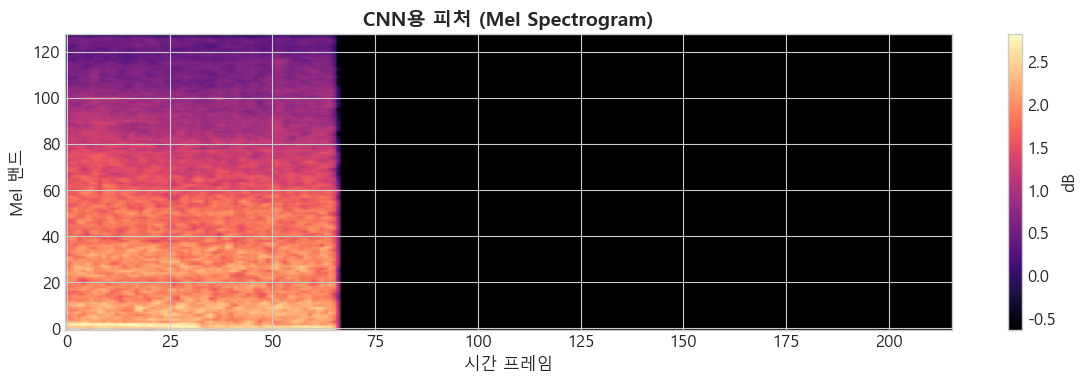

In [28]:
# ============================================================
# CNN용 피처 추출 테스트
# ============================================================

# 정상 브레이크 샘플로 CNN용 피처 추출
sample_path = str(sample_files['정상 브레이크'])

# extract_for_cnn: CNN 모델 입력용 Mel Spectrogram 추출
# 출력: (1, n_mels, time_frames) 형태의 3D 배열
cnn_features = extractor.extract_for_cnn(sample_path)

print(f"📊 CNN용 피처 추출 결과:")
print(f"  Shape: {cnn_features.shape}")
print(f"  - 채널 수: {cnn_features.shape[0]} (Mel Spectrogram)")
print(f"  - Mel 밴드: {cnn_features.shape[1]}")
print(f"  - 시간 프레임: {cnn_features.shape[2]}")
print(f"  Min: {cnn_features.min():.4f}, Max: {cnn_features.max():.4f}")

# 시각화
fig, ax = plt.subplots(figsize=(12, 4))
img = ax.imshow(cnn_features[0], aspect='auto', origin='lower', cmap='magma')
ax.set_xlabel('시간 프레임')
ax.set_ylabel('Mel 밴드')
ax.set_title('CNN용 피처 (Mel Spectrogram)', fontsize=14, fontweight='bold')
fig.colorbar(img, ax=ax, label='dB')
plt.tight_layout()
plt.show()


In [29]:
# ============================================================
# 다양한 피처 추출 테스트
# ============================================================

# 오디오 로드
# load_audio: 파일을 로드하고 config에 설정된 길이로 정규화
y_test, sr_test = extractor.load_audio(sample_path)

print("📊 다양한 피처 추출 테스트\n")

# 1. MFCC 추출
# extract_mfcc(y, sr): MFCC 계수 + Delta + Delta-Delta 추출
mfcc_features = extractor.extract_mfcc(y_test, sr_test)
print(f"1️⃣ MFCC (with Delta):")
print(f"   Shape: {mfcc_features.shape}")
print(f"   - {mfcc_features.shape[0]//3}개 MFCC + {mfcc_features.shape[0]//3} Delta + {mfcc_features.shape[0]//3} Delta2")

# 2. Mel Spectrogram 추출
# extract_mel_spectrogram(y, sr): dB 스케일 Mel Spectrogram
mel_features = extractor.extract_mel_spectrogram(y_test, sr_test)
print(f"\n2️⃣ Mel Spectrogram:")
print(f"   Shape: {mel_features.shape}")
print(f"   - {mel_features.shape[0]} Mel 밴드 x {mel_features.shape[1]} 프레임")

# 3. Chroma 추출 (음악적 음계 특성)
# extract_chroma(y, sr): 12개 음계 기반 피처
chroma_features = extractor.extract_chroma(y_test, sr_test)
print(f"\n3️⃣ Chroma (12 semitones):")
print(f"   Shape: {chroma_features.shape}")

# 4. Spectral Contrast (스펙트럼 대비)
# extract_spectral_contrast(y, sr): 주파수 대역별 대비
contrast_features = extractor.extract_spectral_contrast(y_test, sr_test)
print(f"\n4️⃣ Spectral Contrast:")
print(f"   Shape: {contrast_features.shape}")

# 5. Spectral Features (중심 주파수, 대역폭 등)
# extract_spectral_features(y, sr): 다양한 스펙트럼 통계
spectral_features = extractor.extract_spectral_features(y_test, sr_test)
print(f"\n5️⃣ Spectral Features:")
for name, value in spectral_features.items():
    print(f"   • {name}: shape {value.shape}")


📊 다양한 피처 추출 테스트

1️⃣ MFCC (with Delta):
   Shape: (120, 216)
   - 40개 MFCC + 40 Delta + 40 Delta2

2️⃣ Mel Spectrogram:
   Shape: (128, 216)
   - 128 Mel 밴드 x 216 프레임

3️⃣ Chroma (12 semitones):
   Shape: (12, 216)

4️⃣ Spectral Contrast:
   Shape: (7, 216)

5️⃣ Spectral Features:
   • spectral_centroid: shape (1, 216)
   • spectral_bandwidth: shape (1, 216)
   • spectral_rolloff: shape (1, 216)
   • zero_crossing_rate: shape (1, 216)
   • rms: shape (1, 216)


## 8. 정상 vs 비정상 피처 비교

정상 소리와 비정상 소리의 피처를 나란히 비교하여 차이점을 분석합니다.


🔍 브레이크 상태 비교: 정상 vs 마모


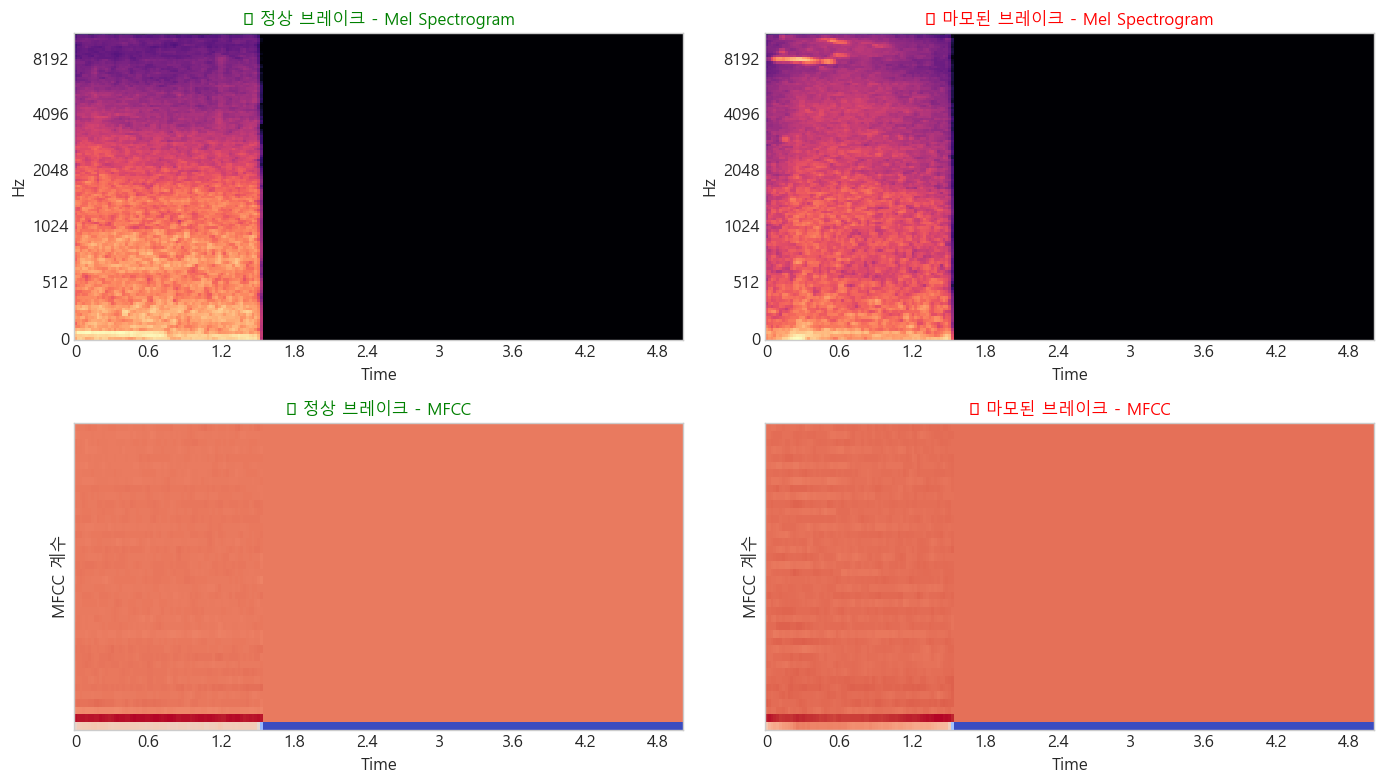

In [30]:
# ============================================================
# 정상 vs 비정상 피처 비교 (브레이크)
# ============================================================

def compare_features(normal_path, abnormal_path, title_normal, title_abnormal):
    """
    정상/비정상 오디오의 피처를 비교 시각화하는 함수
    
    Parameters:
    -----------
    normal_path : str
        정상 오디오 파일 경로
    abnormal_path : str
        비정상 오디오 파일 경로
    title_normal : str
        정상 그래프 제목
    title_abnormal : str
        비정상 그래프 제목
    """
    # 오디오 로드
    y_normal, sr_n = extractor.load_audio(str(normal_path))
    y_abnormal, sr_a = extractor.load_audio(str(abnormal_path))
    
    # 피처 추출
    mel_normal = extractor.extract_mel_spectrogram(y_normal, sr_n)
    mel_abnormal = extractor.extract_mel_spectrogram(y_abnormal, sr_a)
    
    mfcc_normal = extractor.extract_mfcc(y_normal, sr_n, include_delta=False)
    mfcc_abnormal = extractor.extract_mfcc(y_abnormal, sr_a, include_delta=False)
    
    # 시각화
    fig, axes = plt.subplots(2, 2, figsize=(14, 8))
    
    # 좌상: 정상 Mel Spectrogram
    img1 = librosa.display.specshow(mel_normal, sr=sr_n, hop_length=512,
                                     x_axis='time', y_axis='mel', ax=axes[0,0], cmap='magma')
    axes[0,0].set_title(f'✅ {title_normal} - Mel Spectrogram', fontsize=12, color='green')
    
    # 우상: 비정상 Mel Spectrogram
    img2 = librosa.display.specshow(mel_abnormal, sr=sr_a, hop_length=512,
                                     x_axis='time', y_axis='mel', ax=axes[0,1], cmap='magma')
    axes[0,1].set_title(f'❌ {title_abnormal} - Mel Spectrogram', fontsize=12, color='red')
    
    # 좌하: 정상 MFCC
    img3 = librosa.display.specshow(mfcc_normal, sr=sr_n, hop_length=512,
                                     x_axis='time', ax=axes[1,0], cmap='coolwarm')
    axes[1,0].set_title(f'✅ {title_normal} - MFCC', fontsize=12, color='green')
    axes[1,0].set_ylabel('MFCC 계수')
    
    # 우하: 비정상 MFCC
    img4 = librosa.display.specshow(mfcc_abnormal, sr=sr_a, hop_length=512,
                                     x_axis='time', ax=axes[1,1], cmap='coolwarm')
    axes[1,1].set_title(f'❌ {title_abnormal} - MFCC', fontsize=12, color='red')
    axes[1,1].set_ylabel('MFCC 계수')
    
    plt.tight_layout()
    plt.show()

# 브레이크 비교
print("🔍 브레이크 상태 비교: 정상 vs 마모")
compare_features(
    sample_files['정상 브레이크'], 
    sample_files['마모된 브레이크'],
    '정상 브레이크',
    '마모된 브레이크'
)


🔍 공회전 상태 비교: 정상 vs 오일 부족


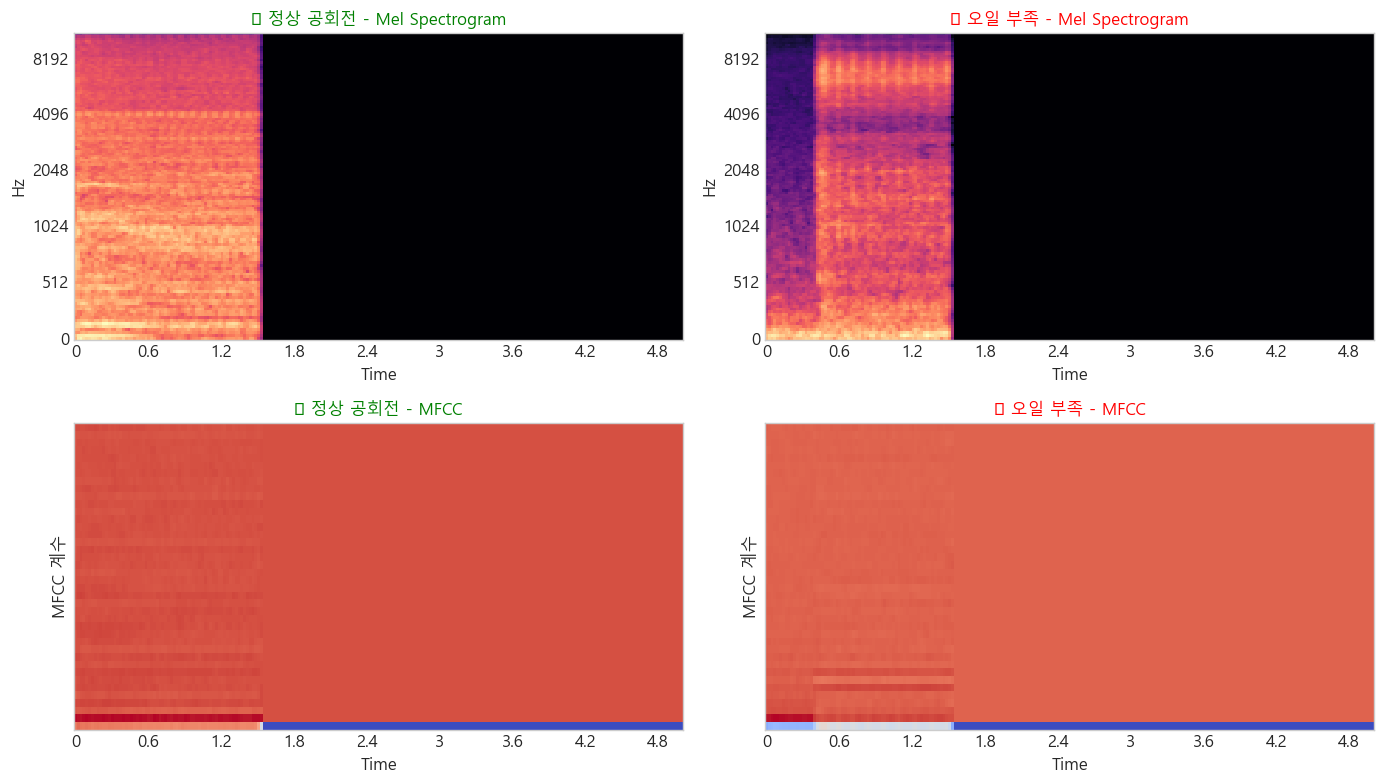

In [31]:
# ============================================================
# 추가 비교: 공회전 상태
# ============================================================

print("🔍 공회전 상태 비교: 정상 vs 오일 부족")
compare_features(
    sample_files['정상 공회전'], 
    sample_files['오일 부족'],
    '정상 공회전',
    '오일 부족'
)


🔍 시동 상태 비교: 정상 vs 배터리 방전


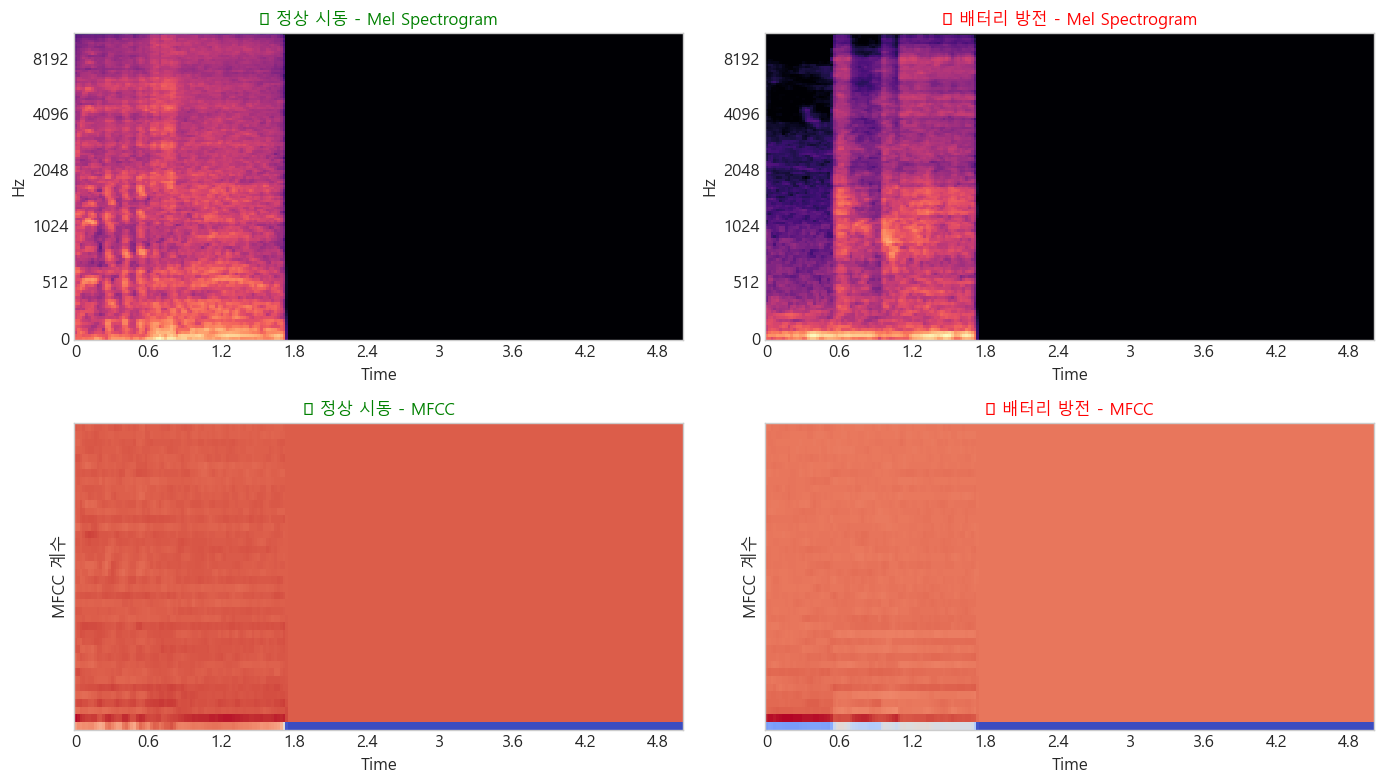

In [32]:
# ============================================================
# 추가 비교: 시동 상태
# ============================================================

print("🔍 시동 상태 비교: 정상 vs 배터리 방전")
compare_features(
    sample_files['정상 시동'], 
    sample_files['배터리 방전'],
    '정상 시동',
    '배터리 방전'
)


## 9. EDA 요약

### 주요 발견 사항

1. **데이터 구조**
   - 3가지 차량 상태: 브레이크, 공회전, 시동
   - 각 상태별 정상/비정상 클래스 존재

2. **피처 특성**
   - **Mel Spectrogram**: 주파수 분포 패턴 시각화에 효과적
   - **MFCC**: 소리의 특성을 압축하여 표현, 분류에 유용
   - **Spectral Features**: 통계적 특성 추출

3. **정상 vs 비정상 차이**
   - 비정상 소리는 불규칙한 패턴이나 특정 주파수 대역에서 이상 신호
   - Mel Spectrogram에서 시각적으로 구분 가능

### 다음 단계

1. 데이터 증강 (Augmentation) 적용
2. CNN/CRNN 모델 학습
3. 성능 평가 및 최적화


In [33]:
# ============================================================
# EDA 완료!
# ============================================================

print("=" * 60)
print("🎉 EDA 완료!")
print("=" * 60)
print(f"""
📊 분석 요약:
  • 총 클래스 수: {len(df_info)}개
  • 총 샘플 수: {df_info['샘플수'].sum()}개
  • 사용된 피처:
    - Waveform (파형)
    - Mel Spectrogram (멜 스펙트로그램)
    - MFCC (멜 주파수 켑스트럼 계수)
    - Chroma (크로마)
    - Spectral Features (스펙트럼 특성)

💡 다음 단계:
  1. 모델 학습: python scripts/train.py --data_dir data --epochs 50
  2. 결과 분석: 학습 로그 및 혼동 행렬 확인
""")
print("=" * 60)


🎉 EDA 완료!

📊 분석 요약:
  • 총 클래스 수: 22개
  • 총 샘플 수: 3269개
  • 사용된 피처:
    - Waveform (파형)
    - Mel Spectrogram (멜 스펙트로그램)
    - MFCC (멜 주파수 켑스트럼 계수)
    - Chroma (크로마)
    - Spectral Features (스펙트럼 특성)

💡 다음 단계:
  1. 모델 학습: python scripts/train.py --data_dir data --epochs 50
  2. 결과 분석: 학습 로그 및 혼동 행렬 확인

